## Installing Libraries
Here we use pip to install libraries

In [1]:
#!pip install -r requirements.txt 

## Import Libraries
Here we import the libraries we use

In [2]:
import os
import sqlite3
import pandas as pd

# import of own functions
from scripts import save_load, plot_funktion, similarity, HSV, cnn_model

2023-07-02 02:21:28.527728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Creating database sqlite3
Here we create a database and a table to store image IDs, image paths and image labels

In [3]:
# Create the database folder if it does not exist
if not os.path.exists('databases'):
    os.makedirs('databases')

In [4]:
# Connects to .db file with SQLite
conn = sqlite3.connect("databases/image_database.db")
curs = conn.cursor()

In [5]:
# Create the image_paths table with the desired columns and constraints
curs.execute("""CREATE TABLE IF NOT EXISTS image_paths 
                (image_id text UNIQUE PRIMARY KEY, 
                image_path text UNIQUE,
                CONSTRAINT unique_path_and_id UNIQUE(image_id, image_path));""")

In [6]:
# Check if there are values already in existing in the table
curs.execute("SELECT * FROM image_paths;")
curs.fetchall()

[('bd3044f8-5858-487e-a650-13e4c16e2c7c',
  'images/weather_image_recognition/lightning/2100.jpg',
  'lightning'),
 ('28b2322f-cb07-447c-8f15-67e872572f13',
  'images/weather_image_recognition/lightning/2114.jpg',
  'lightning'),
 ('c7e35ce6-ea4d-4302-9cb3-c802fadcd18a',
  'images/weather_image_recognition/lightning/2128.jpg',
  'lightning'),
 ('bdf443cc-2021-4b3e-a69e-a68385291b5c',
  'images/weather_image_recognition/lightning/1838.jpg',
  'lightning'),
 ('f949d010-e199-45e7-bd3c-5a1524de5504',
  'images/weather_image_recognition/lightning/1964.jpg',
  'lightning'),
 ('9fce4ff1-cff5-4ca6-ad51-65e896505e88',
  'images/weather_image_recognition/lightning/1970.jpg',
  'lightning'),
 ('3d22d72c-2c03-4025-893c-52c8da0ecab0',
  'images/weather_image_recognition/lightning/1958.jpg',
  'lightning'),
 ('317b6e5f-8a68-44f7-9ba3-e2419af00f69',
  'images/weather_image_recognition/lightning/2074.jpg',
  'lightning'),
 ('ce7f5da7-8e0f-4963-b651-d99ddbe0ca53',
  'images/weather_image_recognition/li

## Database loader
Here implement the generators and use SQLite commands to load each row entry to our iamge_paths table in our database

In [7]:
from scripts import generator as gen

path = "images" # local path

# create our generator class from our generator script
row_gen = gen.main_generator(path)

In [8]:
#curs.execute("DROP TABLE image_paths;")

In [ ]:
# Inserting each row into the image_paths table using SQL commands
def database_loader(row_gen):
    while True:
        try:
            curs.execute("""INSERT INTO image_paths VALUES (?,?);""", next(row_gen))
            conn.commit()
        except StopIteration:
            break
        except Exception as e:
            print("Error loading the following file:", e)
        continue
database_loader(row_gen)

In [ ]:
# Here we select all entries from image_paths table to see if our row loader functions
curs.execute("SELECT * FROM image_paths;")
curs.fetchall()

## Converting database table into pandas dataframe
Here we convert our newly-generated table with its values into a pandas dataframe 

In [5]:
# Create a dataframe with values from image_paths table
sql_query = "SELECT * FROM image_paths"
results = pd.read_sql(sql_query, con=conn)
results

,image_id,image_path,label
0,bd3044f8-5858-487e-a650-13e4c16e2c7c,images/weather_image_recognition/lightning/210...,lightning
1,28b2322f-cb07-447c-8f15-67e872572f13,images/weather_image_recognition/lightning/211...,lightning
2,c7e35ce6-ea4d-4302-9cb3-c802fadcd18a,images/weather_image_recognition/lightning/212...,lightning
3,bdf443cc-2021-4b3e-a69e-a68385291b5c,images/weather_image_recognition/lightning/183...,lightning
4,f949d010-e199-45e7-bd3c-5a1524de5504,images/weather_image_recognition/lightning/196...,lightning
...,...,...,...
6858,587a24f0-0db4-4849-a3d9-42987582cce8,images/weather_image_recognition/snow/1438.jpg,snow
6859,6edfb5b6-27b8-4535-8f4a-95d0813b82a2,images/weather_image_recognition/snow/1362.jpg,snow
6860,04ea775a-7a46-4d8e-b472-6770d0535db7,images/weather_image_recognition/snow/1404.jpg,snow
6861,1ebe62e0-ce0d-4dfe-b846-d93e912bcb34,images/weather_image_recognition/snow/1410.jpg,snow


## CNN-Model

In [8]:
# Load all created embeddings
cnn_embeddings = save_load.load_pkl("cnn_embedding.pkl")

In [ ]:
# Create cnn embedding
cnn_embeddings = cnn_model.create_cnn_embedding(dfss, 
                                                model_name="resnet", 
                                                pooling="globavg", 
                                                test=False, 
                                                log_file="logfile.log", 
                                                pkl_save="cnn_embedding.pkl")

In [59]:
cnn_sim_df = similarity.similarity_computation(cnn_embeddings[0], cnn_embeddings, scoring_method=similarity.euclidean_distance)
index_values = cnn_sim_df.index.tolist()

# Retrieve the contents of the image_paths in the image_paths_df dataframe based on the index of the distances_df
column_values = results.loc[index_values, "image_path"]
# Ergebnis anzeigen
cnn_df_sim_path = pd.DataFrame(column_values)

100%|██████████| 6862/6862 [00:00<00:00, 97622.68it/s]


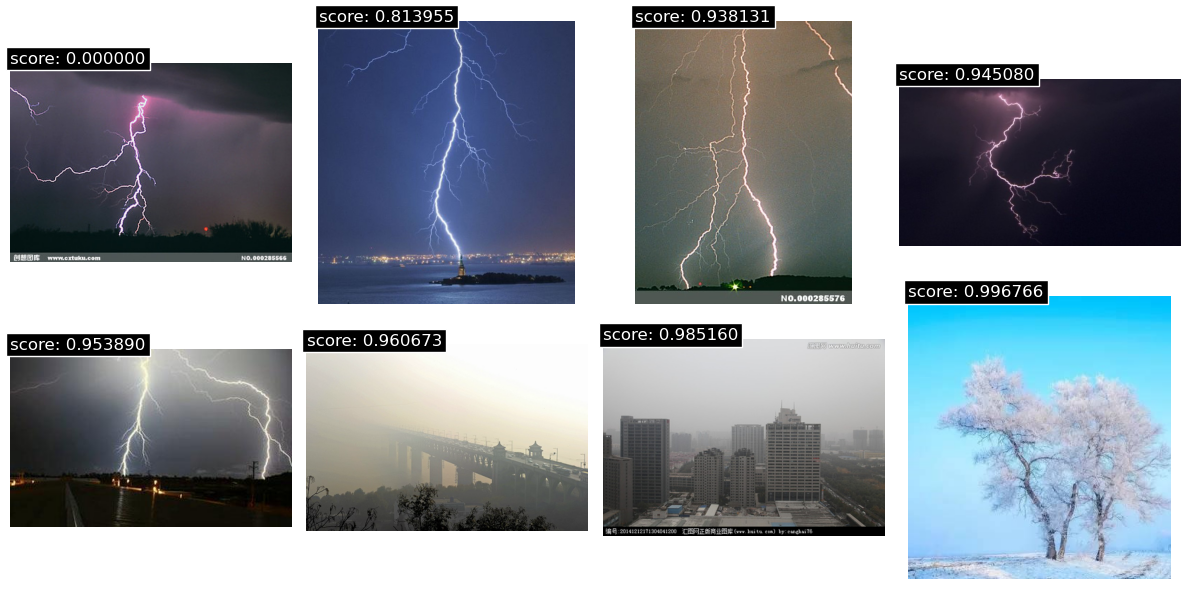

In [58]:
top_8_paths, top_8_score = plot_funktion.top_8_gen(cnn_df_sim_path, cnn_sim_df)
plot_funktion.images_grid(top_8_paths, top_8_score)

## HSV Funktion

In [10]:
hs_vectors = HSV.create_color_vec(results, metric="hs", test=True)

100%|██████████| 1201/1201 [00:19<00:00, 60.74it/s]


In [11]:
hs_sim_df = similarity.similarity_computation(hs_vectors[0], hs_vectors, scoring_method=similarity.cosine_similarity)
index_values = hs_sim_df.index.tolist()

# Retrieve the contents of the image_paths in the image_paths_df dataframe based on the index of the distances_df
column_values = results.loc[index_values, "image_path"]
# Ergebnis anzeigen
hs_df_sim_path = pd.DataFrame(column_values)

100%|██████████| 1201/1201 [00:00<00:00, 3903.76it/s]


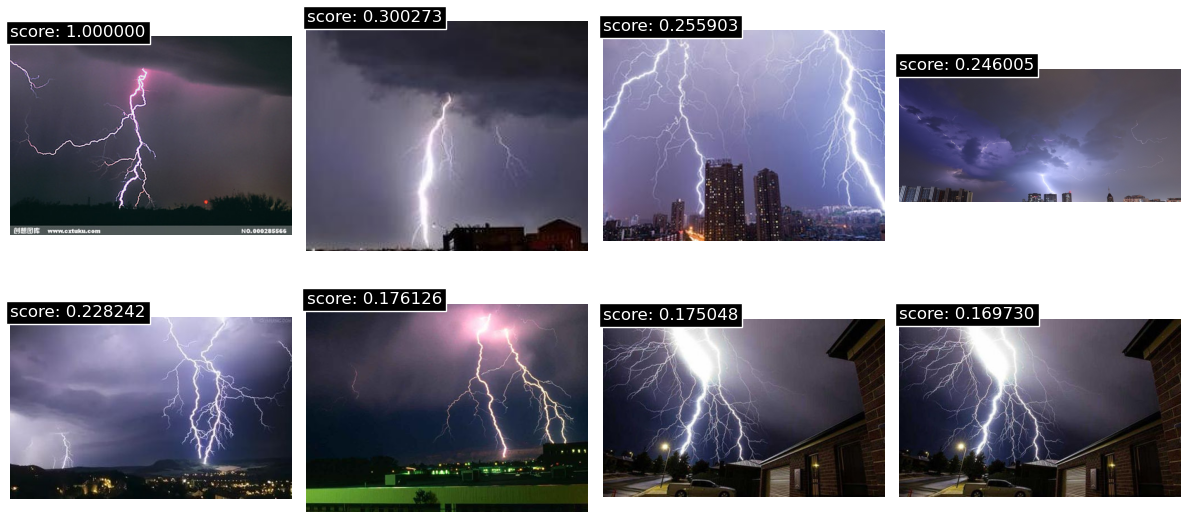

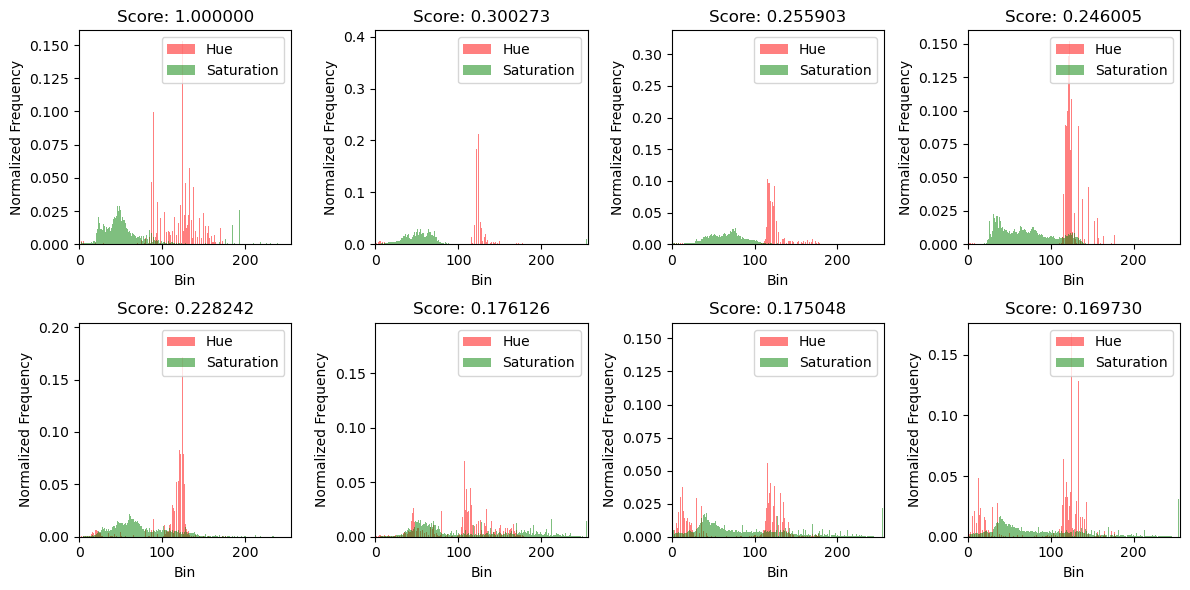

In [12]:
top_8_paths, top_8_score = plot_funktion.top_8_gen(hs_df_sim_path, hs_sim_df)
plot_funktion.images_grid(top_8_paths, top_8_score)
plot_funktion.images_histogram_grid(top_8_paths, top_8_score, V=False)

In [7]:
v_vectors = HSV.create_color_vec(results, metric="v", test=True)

100%|██████████| 1201/1201 [00:04<00:00, 286.58it/s]


In [8]:
v_sim_df = similarity.similarity_computation(v_vectors[0], v_vectors, scoring_method=similarity.cosine_similarity)
index_values = v_sim_df.index.tolist()

# Retrieve the contents of the image_paths in the image_paths_df dataframe based on the index of the distances_df
column_values = results.loc[index_values, "image_path"]
# Ergebnis anzeigen
v_df_sim_path = pd.DataFrame(column_values)

100%|██████████| 1201/1201 [00:00<00:00, 20867.01it/s]


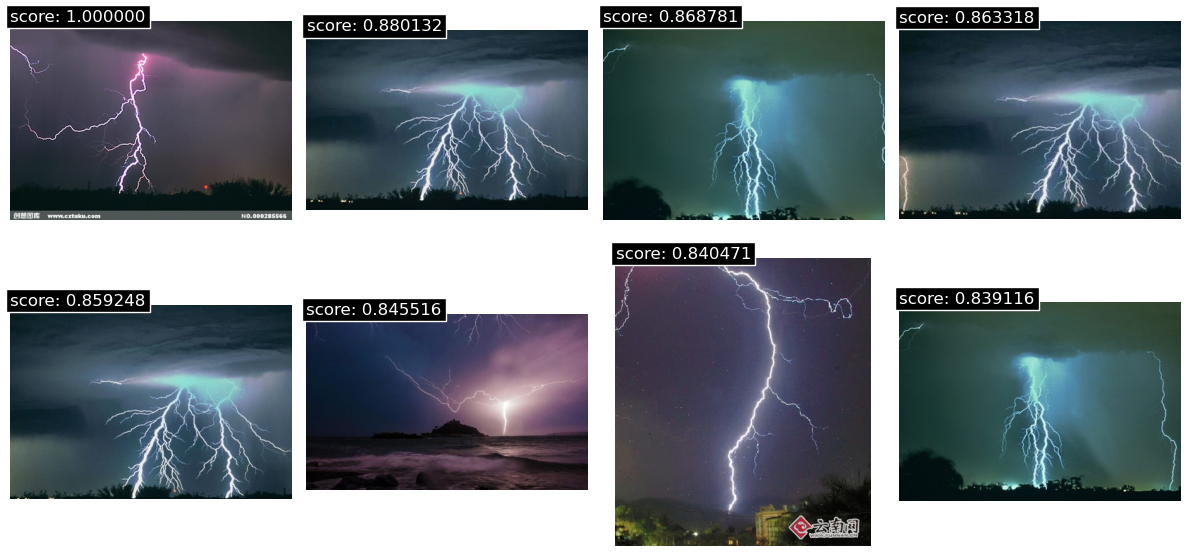

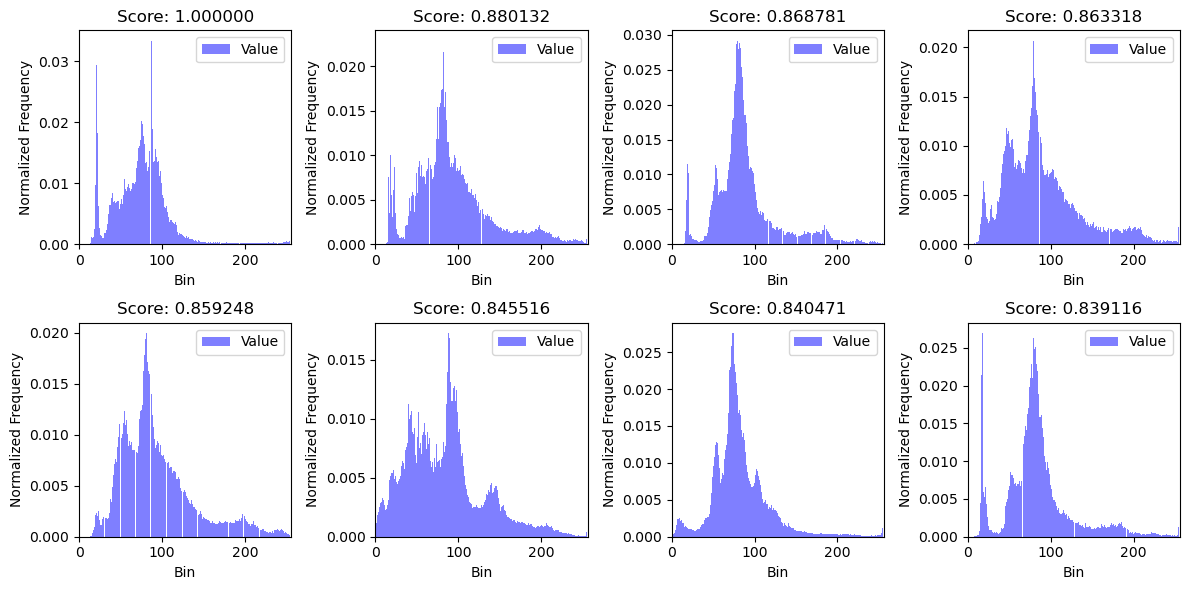

In [9]:
top_8_paths, top_8_score = plot_funktion.top_8_gen(v_df_sim_path, v_sim_df)
plot_funktion.images_grid(top_8_paths, top_8_score)
plot_funktion.images_histogram_grid(top_8_paths, top_8_score, H=False, S=False)